In [1]:
import os
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR, StepLR

In [2]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "clip/bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


In [3]:
# from clip import clip
# from clip import model

# model, preprocess = clip.load("ViT-B/32", device='cuda', jit=False)

model = torch.jit.load("checkpoints/model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Load LAD Dataset

In [4]:
data_root = '/media/hxd/82231ee6-d2b3-4b78-b3b4-69033720d8a8/MyDatasets/LAD/LAD_annotations/'
img_root = '/media/hxd/82231ee6-d2b3-4b78-b3b4-69033720d8a8/MyDatasets/LAD/LAD_images/'

In [5]:
# load attributes list
attributes_list_path = data_root + 'attribute_list.txt'
fsplit = open(attributes_list_path, 'r', encoding='UTF-8')
lines_attribute = fsplit.readlines()
fsplit.close()
list_attribute = list()
list_attribute_value = list()
for each in lines_attribute:
    tokens = each.split(', ')
    list_attribute.append(tokens[0])
    list_attribute_value.append(tokens[1])

In [6]:
# load label list
label_list_path = data_root + 'label_list.txt'
fsplit = open(label_list_path, 'r', encoding='UTF-8')
lines_label = fsplit.readlines()
fsplit.close()
list_label = dict()
list_label_value = list()
for each in lines_label:
    tokens = each.split(', ')
    list_label[tokens[0]]=tokens[1]
    list_label_value.append(tokens[1])

In [7]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize((224, 224), interpolation=Image.BICUBIC),
    CenterCrop((224, 224)),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

/home/hxd/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [8]:
# load all the labels, attributes, images data from the LAD dataset
attributes_per_class_path = data_root + 'attributes.txt'
fattr = open(attributes_per_class_path, 'r', encoding='UTF-8')
lines_attr = fattr.readlines()
fattr.close()
images = list()
attr = list()
labels = list()
for each in lines_attr:
    tokens = each.split(', ')
    labels.append(list_label[tokens[0]])
    img_path = tokens[1]
    image = preprocess(Image.open(os.path.join(img_root, img_path)).convert("RGB"))
    images.append(image)
    attr_r = list(map(int, tokens[2].split()[1:-1]))
    attr.append([val for i,val in enumerate(list_attribute_value) if attr_r[i] == 1])

In [9]:
# normalize images
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [10]:
# Convert labels to tokens
tokenizer_label = SimpleTokenizer()
text_tokens = [tokenizer_label.encode(desc) for desc in labels]

sot_token = tokenizer_label.encoder['<|startoftext|>']
eot_token = tokenizer_label.encoder['<|endoftext|>']

text_inputs_label = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_inputs_label[i, :len(tokens)] = torch.tensor(tokens)
text_inputs_label = text_inputs_label.cuda()

In [11]:
# Convert attributes to tokens
tokenizer_att = SimpleTokenizer()
text_tokens = [[tokenizer_att.encode(desc) for desc in att] for att in attr]

sot_token = tokenizer_att.encoder['<|startoftext|>']
eot_token = tokenizer_att.encoder['<|endoftext|>']
text_inputs_att = list()

for j, tokens_img in enumerate(text_tokens):
    text_input = torch.zeros(len(tokens_img), model.context_length, dtype=torch.long)
    for i, tokens in enumerate(tokens_img):
        tokens = [sot_token] + tokens + [eot_token]
        text_input[i, :len(tokens)] = torch.tensor(tokens)
    text_inputs_att.append(text_input.cuda())


In [12]:
# Use CLIP to obtain image and text features

In [13]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

/tmp/ipykernel_1844505/3267874097.py:2: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  image_features = model.encode_image(image_input).float()


In [14]:
with torch.no_grad():
    label_fea = model.encode_text(text_inputs_label.cuda()).float()

In [15]:
with torch.no_grad():
    text_feature = list()
    for txt in text_inputs_att:
        if len(txt) == 0:
            text_feature.append(torch.empty(0, 512).cuda())
        else:
            text_feature.append(model.encode_text(txt).float())

# Skip previous steps: directly load processed image features; load attribute features; load label features for each image

In [16]:
with open('../checkpoints/data_txt_feature.pkl', 'rb') as file:
    b = pickle.load(file)

label_fea = b['label']
text_feature = b['att']

In [17]:
with open('../checkpoints/data_img_feature.pkl', 'rb') as file:
    image_features = pickle.load(file)
    
image_features /= image_features.norm(dim=-1, keepdim=True)

In [18]:
label_fea /= label_fea.norm(dim=-1, keepdim=True)

In [19]:
text_feature = torch.stack([torch.mean(item,0) for item in text_feature])
text_feature /= text_feature.norm(dim=-1, keepdim=True)

# Construct the dataloader

In [22]:
from torch.utils.data import Dataset
from sklearn import preprocessing

class Dataset(Dataset):

    def __init__(self, image_features, text_feature, labels, data_indx):
        self.image_features = image_features
        self.text_feature = text_feature
        self.labels = labels
        self.data_indx = data_indx
#         self.imgs = image_input
#         self.attr = attr

    def __len__(self):
        return len(self.image_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'image': self.image_features[idx], 
                  'attribute': self.text_feature[idx], 
                  'label': self.labels[idx],
                  'data_indx': self.data_indx[idx]
#                   'imgs': self.imgs[idx],
#                   'attr': self.attr[idx]
                 }

        return sample
   

le = preprocessing.LabelEncoder()
le.fit(labels)
class_list = list(le.classes_)
labels_list = torch.tensor(le.transform(labels)).cuda()

attr_ = [';'.join(attr[0]) for item in attr]
data_indx = list(range(4600))
# dataset = Dataset(image_features, text_feature, labels_list, torch.tensor(np.stack(images)).cuda(), attr_)
dataset = Dataset(image_features, text_feature, labels_list, data_indx)
train_set, test_set = torch.utils.data.random_split(dataset,[4600-500,500])
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [23]:
import torch.nn as nn
from torch.utils.data import DataLoader
# defining the model architecture
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(1024, 512),
          nn.Linear(512, 230)
      )

  # Defining the forward pass    
  def forward(self, x, t):
#       x = self.cnn_layers(x)
#       x = x.view(x.size(0), -1)
      con = torch.cat((x, t), 1)
      out = self.linear_layers(con)
      return out

In [24]:
model = Net().cuda()
error = nn.CrossEntropyLoss().cuda()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [25]:
num_epochs = 30
# Lists for visualization of loss and accuracy 
epoch_list = []
train_accuracy_list = []
train_loss_list = []
valid_accuracy_list = []
valid_loss_list = []
PATH = "../checkpoints/cnn.pth"

for epoch in range(num_epochs):
    correct = 0
    running_loss = 0
    model.train()
    for data in trainloader:
        # Transfering images and labels to GPU if available
#         image_batch, text_batch, label_batch, im_batch, att_batch = data['image'], data['attribute'], data['label'], data['imgs'], data['attr']
        image_batch, text_batch, label_batch, idx_batch = data['image'], data['attribute'], data['label'], data['data_indx']
        # Forward pass 
        outputs = model(image_batch, text_batch)
        #CrossEntropyLoss expects floating point inputs and long labels.
        loss = error(outputs, label_batch)
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        #Propagating the error backward
        loss.backward()
        # Optimizing the parameters
        optimizer.step()
    
        predictions = torch.max(outputs, 1)[1].cuda()
        correct += (predictions == label_batch).sum()
        running_loss += loss.item()

    train_loss_list.append(float(running_loss) / float(len(trainloader.dataset)))
    train_accuracy_list.append(float(correct) / float(len(trainloader.dataset)))
    
    # test on validation set
    correct = 0
    running_loss = 0
    with torch.no_grad():
        for data in testloader:
            image_batch, text_batch, label_batch, idx_batch = data['image'], data['attribute'], data['label'], data['data_indx']

            outputs = model(image_batch, text_batch)

            predictions = torch.max(outputs, 1)[1].cuda()
            correct += (predictions == label_batch).sum()
            running_loss += loss.item()


                               
    valid_loss_list.append(float(running_loss) / float(len(testloader.dataset)))
    valid_accuracy_list.append(float(correct) / float(len(testloader.dataset)))
                               
    print("Epoch: {}, train_loss: {}, train_accuracy: {}%, test_loss: {}, test_accuracy: {}%".format(epoch, 
                                                      train_loss_list[-1], 
                                                      train_accuracy_list[-1], 
                                                      valid_loss_list[-1], 
                                                      valid_accuracy_list[-1]))
            
    
                          
    epoch_list.append(epoch)     
    scheduler.step()
    
    if (epoch % 10) == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, PATH)

Epoch: 0, train_loss: 0.04755550233329215, train_accuracy: 0.30048780487804877%, test_loss: 0.03341913604736328, test_accuracy: 0.608%
Epoch: 1, train_loss: 0.010831539638158751, train_accuracy: 0.7958536585365854%, test_loss: 0.011032847404479981, test_accuracy: 0.782%
Epoch: 2, train_loss: 0.005366428843358668, train_accuracy: 0.8953658536585366%, test_loss: 0.008525192260742187, test_accuracy: 0.788%
Epoch: 3, train_loss: 0.0033682722125838445, train_accuracy: 0.9448780487804878%, test_loss: 0.017572683334350588, test_accuracy: 0.83%
Epoch: 4, train_loss: 0.0037568298790876457, train_accuracy: 0.9409756097560975%, test_loss: 0.0003965389132499695, test_accuracy: 0.832%
Epoch: 5, train_loss: 0.0016393478616799524, train_accuracy: 0.9682926829268292%, test_loss: 0.00014771847426891326, test_accuracy: 0.826%
Epoch: 6, train_loss: 0.0007157210025527491, train_accuracy: 0.9882926829268293%, test_loss: 9.183893352746964e-05, test_accuracy: 0.848%
Epoch: 7, train_loss: 0.000429107019302957

In [26]:
m = nn.Softmax()

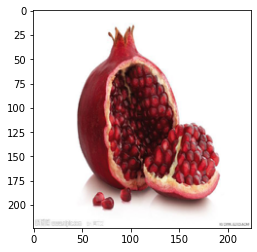

torch.return_types.topk(
values=tensor([9.9639e-01, 2.5585e-03, 6.2551e-04], grad_fn=<TopkBackward>),
indices=tensor([160, 124,  94]))
['pomegranate', 'lychee', 'hawthorn']
['outside color: is red', 'outside color: is transparent', 'size: is small (compared to apples)', 'size: is middle (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'taste: tastes sour', 'taste: tastes puckery', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is shredded', 'current state: has been processed', 'hardness: is soft', 'edibility: is common', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: has seeds', 'growth: is tropical', 'growth: grows on trees', 'medicinal property: is warm or hot']


/tmp/ipykernel_1844505/261448579.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(m(outputs[id]).cpu().topk(3, dim=-1))
/tmp/ipykernel_1844505/261448579.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  top3 = m(outputs[id]).cpu().topk(3, dim=-1).indices


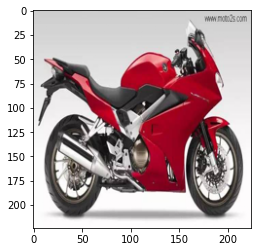

torch.return_types.topk(
values=tensor([9.9991e-01, 7.2217e-05, 1.0649e-05], grad_fn=<TopkBackward>),
indices=tensor([137, 204,  27]))
['motorcycle', 'three-wheeled_motorcycle', 'car']
['color: is black', 'color: is gray', 'color: is red', 'size: is small (compared to cars)', 'shape: is long', 'speed: moves fast', 'parts: has seats', 'parts: has a engine', 'parts: has a horn', 'parts: has a brake', 'parts: has a number plate', 'parts: has two wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a small quantity (≤ 1 ton) of goods', 'aim: is for civil use', 'aim: is for family', 'aim: is for sports', 'power: consumes gasoline', 'usage scenarios: can be used on urban roads', 'usage scenarios: can be used on rural roads', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


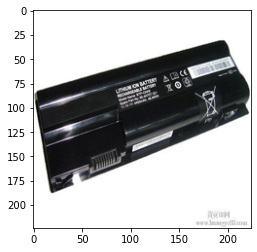

torch.return_types.topk(
values=tensor([9.9997e-01, 1.5681e-05, 6.7858e-06], grad_fn=<TopkBackward>),
indices=tensor([113, 114, 229]))
['laptop_battery', 'laptop_power_adapter', 'yam']
['color: is black', 'size: is big (compared to a mobile phone)', 'parts: has a battery', 'aim: is for business', 'aim: is for family', 'aim: is for office use', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is movable', 'sound: is quiet', 'power: is a low-power (≤100 w) device']


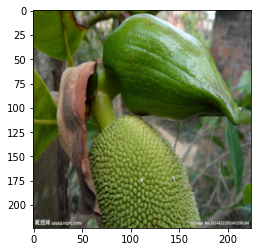

torch.return_types.topk(
values=tensor([9.9736e-01, 1.9522e-03, 1.8848e-04], grad_fn=<TopkBackward>),
indices=tensor([104,  28,  92]))
['jackfruit', 'carambola', 'hami_melon']
['outside color: is cyan', 'outside color: is green', 'size: is big (compared to apples)', 'shape: is ellipsoidal', 'shape: is long', 'taste: tastes sweet', 'taste: tastes sour', 'smell: is smelly', 'marking: has patches', 'epidermis: is rough', 'epidermis: has peel', 'current state: is complete', 'current state: is raw', 'hardness: is hard', 'edibility: is rare', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: needs to be skinned', 'edibility: has nutlets', 'edibility: has seeds', 'growth: is tropical', 'growth: grows on trees', 'medicinal property: is mild']


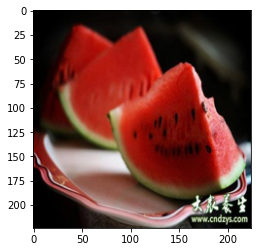

torch.return_types.topk(
values=tensor([0.9392, 0.0327, 0.0256], grad_fn=<TopkBackward>),
indices=tensor([224, 155,  92]))
['watermelon', 'pitaya', 'hami_melon']
['size: is small (compared to apples)', 'taste: tastes sweet', 'marking: has stripes', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is shredded', 'current state: has been processed', 'hardness: is soft', 'edibility: is common', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: has seeds', 'growth: grows on the ground', 'medicinal property: is cool or cold']


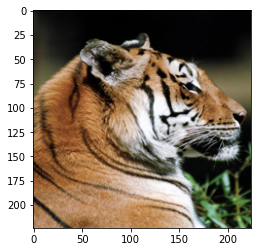

torch.return_types.topk(
values=tensor([0.9957, 0.0029, 0.0012], grad_fn=<TopkBackward>),
indices=tensor([205, 121, 118]))
['tiger', 'lion', 'leopard']
['color: is black', 'color: is white', 'color: is brown', 'color: is yellow', 'appearance: is furry', 'appearance: has soft skin', 'appearance: is smooth', 'appearance: has whiskers', 'marking: has stripes', 'size: is big (compared to pigs)', 'limb: has long legs', 'limb: has four legs', 'paws: has paws', 'paws: has pads', 'neck: has a long neck', 'teeth: has teeth', 'teeth: has buck teeth', 'tail: has a long tail', 'tail: has a colorful tail', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can walk', 'behaviour: can jump', 'diet: eats meat', 'habit: moves fast', 'habit: is strong', 'habit: has muscle', 'habit: is fierce', 'habit: is smart', 'habit: is active', 'habit: is the predator', 'h

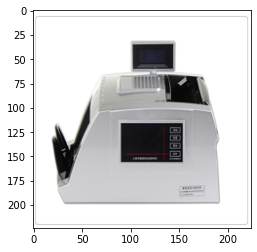

torch.return_types.topk(
values=tensor([9.9865e-01, 6.5163e-04, 1.6808e-04], grad_fn=<TopkBackward>),
indices=tensor([ 46, 165, 164]))
['counting_machine', 'projector', 'printer']
['color: is black', 'color: is gray', 'size: is big (compared to a mobile phone)', 'weight: weighs kilograms', 'parts: has a small screen (≤10 inches)', 'parts: has an audio', 'parts: has a motor', 'parts: has a fan', 'parts: has keys', 'parts: has a plug', 'parts: has indicator lights', 'function: can give out lights', 'function: can show characters', 'aim: is for business', 'aim: is for family', 'aim: is for office use', 'aim: is for display', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is movable', 'sound: is noisy', 'power: is a low-power (≤100 w) device']


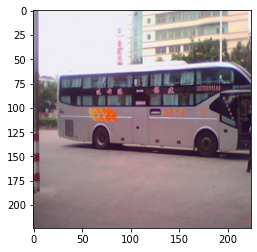

torch.return_types.topk(
values=tensor([0.9950, 0.0016, 0.0011], grad_fn=<TopkBackward>),
indices=tensor([ 39, 210,  57]))
['coach', 'train', 'double-decker_bus']
['color: is black', 'size: is big (compared to cars)', 'weight: weighs tons', 'shape: is long', 'speed: moves fast', 'parts: has doors', 'parts: has seats', 'parts: has windows', 'parts: has a engine', 'parts: has a horn', 'parts: has a steering wheel', 'parts: has a brake', 'parts: has a number plate', 'parts: has a sunroof', 'parts: has four wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a larger number (＞10)  of passengers', 'function: can carry a large quantity (＞ 1 tons) of goods', 'aim: is for civil use', 'power: consumes diesel oil', 'usage scenarios: can be used on urban roads', 'usage scenarios: can be used on rural roads', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


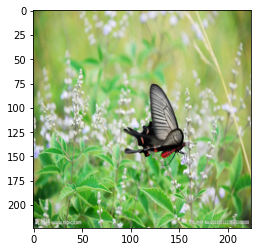

torch.return_types.topk(
values=tensor([0.9664, 0.0288, 0.0021], grad_fn=<TopkBackward>),
indices=tensor([ 23, 140,  58]))
['butterfly', 'mulberry_fruit', 'dragonfly']
['color: is black', 'color: is gray', 'appearance: is hairless', 'appearance: has soft skin', 'marking: has spots', 'marking: has stripes', 'size: is small (compared to pigs)', 'limb: has short legs', 'wing: has long wings', 'other body parts: has eyes', 'behaviour: can fly', 'diet: eats plants', 'diet: eats leaves', 'diet: eats nectar', 'habit: moves fast', 'habit: is weak', 'habit: is friendly', 'habit: is timid', 'habit: is active', 'habit: can hibernate', 'habit: lives in groups', 'habit: is quiet', 'habit: is cold-blooded', 'habitat: lives in fields', 'habitat: lives in the jungle', 'habitat: lives on the ground']


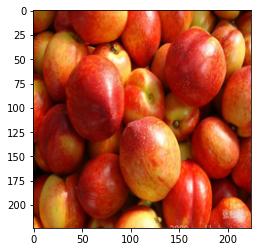

torch.return_types.topk(
values=tensor([0.9778, 0.0148, 0.0057], grad_fn=<TopkBackward>),
indices=tensor([149,   7, 160]))
['peach', 'apple', 'pomegranate']
['outside color: is cyan', 'outside color: is red', 'outside color: is yellow', 'size: is small (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'taste: tastes sour', 'smell: is fragrant', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is complete', 'current state: is raw', 'hardness: is soft', 'edibility: is common', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: has nutlets', 'growth: grows on trees', 'medicinal property: is warm or hot']


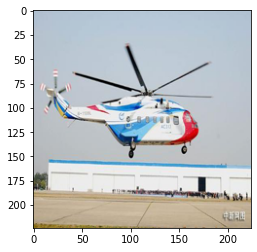

torch.return_types.topk(
values=tensor([9.9918e-01, 4.2380e-04, 1.6727e-04], grad_fn=<TopkBackward>),
indices=tensor([37,  9, 62]))
['civilian_helicopter', 'armed_helicopter', 'eagle']
['color: is white', 'color: is blue', 'color: is cyan', 'size: is big (compared to cars)', 'weight: weighs tons', 'shape: is long', 'speed: moves fast', 'parts: has doors', 'parts: has seats', 'parts: has windows', 'parts: has a engine', 'parts: has a propeller', 'parts: has three wheels', 'parts: has lights', 'function: can fly ', 'function: can move', 'function: can be driven', 'function: can carry a larger number (＞10)  of passengers', 'function: can carry a large quantity (＞ 1 tons) of goods', 'aim: is for rescue', 'aim: is for civil use', 'aim: is for military', 'power: consumes special fuel', 'usage scenarios: can be used in the sky', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


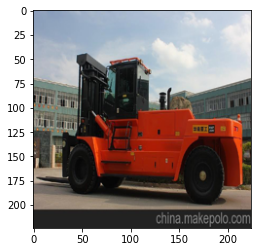

torch.return_types.topk(
values=tensor([0.5623, 0.1412, 0.1320], grad_fn=<TopkBackward>),
indices=tensor([ 78, 209,  48]))
['forklift', 'tractor_semitrailer', 'crane']
['color: is black', 'color: is orange', 'size: is middle (compared to cars)', 'weight: weighs tons', 'shape: is long', 'speed: moves slowly', 'parts: has doors', 'parts: has seats', 'parts: has windows', 'parts: has a engine', 'parts: has a horn', 'parts: has a steering wheel', 'parts: has a brake', 'parts: has four wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a large quantity (＞ 1 tons) of goods', 'aim: is for engineering', 'aim: is for civil use', 'power: consumes diesel oil', 'usage scenarios: can be used on urban roads', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


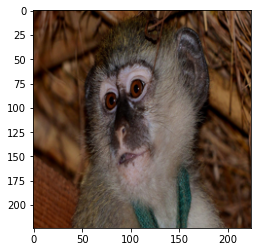

torch.return_types.topk(
values=tensor([9.9941e-01, 3.7584e-04, 3.6944e-05], grad_fn=<TopkBackward>),
indices=tensor([134, 110, 119]))
['monkey', 'koala', 'lesser_panda']
['color: is brown', 'color: is gray', 'appearance: is furry', 'appearance: has soft skin', 'marking: has patches', 'size: is small (compared to pigs)', 'limb: has long legs', 'limb: has four legs', 'limb: has two arms', 'paws: has paws', 'paws: has pads', 'neck: has a long neck', 'teeth: has teeth', 'tail: has a long tail', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can walk', 'behaviour: can jump', 'behaviour: can climb trees', 'diet: eats plants', 'diet: eats insects', 'diet: eats fish', 'diet: eats leaves', 'diet: eats meat', 'diet: eats seeds', 'diet: eats nectar', 'habit: moves fast', 'habit: is weak', 'habit: has muscle', 'habit: is friendly', 'habit: is timid'

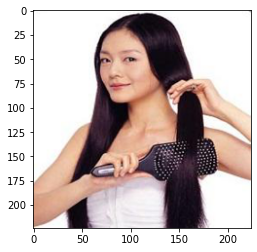

torch.return_types.topk(
values=tensor([0.9947, 0.0018, 0.0016], grad_fn=<TopkBackward>),
indices=tensor([218,  97, 225]))
['waist-length_hair', 'hime_cut', 'wave_hair']
['color: is black', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with a hat', 'fitness: fits people with ear rings', 'fitness: fits people with heavy make-up', 'feeling: is easy to be messy', 'feeling: is simple', 'feeling: is elegant', 'feeling: is sexy', 'feeling: is mature', 'feeling: is pure']


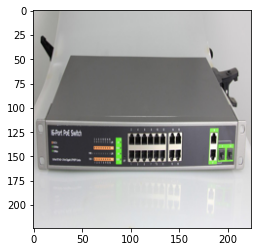

torch.return_types.topk(
values=tensor([9.9520e-01, 4.2465e-03, 3.3537e-04], grad_fn=<TopkBackward>),
indices=tensor([197, 177,  93]))
['switch', 'router', 'hard_disk']
['color: is black', 'color: is gray', 'size: is big (compared to a mobile phone)', 'weight: weighs kilograms', 'shape: is flat', 'parts: has many network interfaces', 'parts: has keys', 'parts: has an antenna', 'parts: has a plug', 'parts: has indicator lights', 'function: can give out lights', 'function: can transmit signal', 'function: can communicate in a short distance', 'function: can communicate in a long distance', 'aim: is for business', 'aim: is for communication', 'aim: is for family', 'aim: is for office use', 'aim: is for display', 'aim: is for safety', 'aim: is for personal', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is movable', 'sound: is quiet', 'power: is a low-power (≤100 w) device']


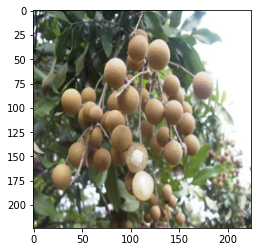

torch.return_types.topk(
values=tensor([0.9922, 0.0036, 0.0031], grad_fn=<TopkBackward>),
indices=tensor([122, 123, 150]))
['longan', 'loquat', 'pear']
['outside color: is white', 'outside color: is yellow', 'outside color: is transparent', 'size: is small (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'epidermis: is rough', 'epidermis: has crust', 'current state: is complete', 'current state: is shelled', 'current state: is raw', 'current state: has been processed', 'hardness: is soft', 'hardness: is hard', 'edibility: is common', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: needs to be skinned', 'edibility: has nutlets', 'growth: is tropical', 'growth: grows on trees', 'medicinal property: is warm or hot']


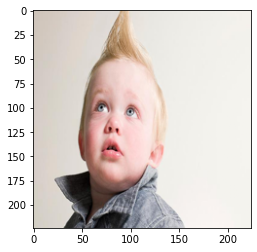

torch.return_types.topk(
values=tensor([0.3452, 0.1604, 0.1571], grad_fn=<TopkBackward>),
indices=tensor([133, 100,  21]))
['mohawk', 'horseshoe_flattop', 'bowl_cut']
['color: is golden', 'fitness: fits people with small eyes', 'fitness: fits people with moustache', 'fitness: fits people with beard', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'feeling: is simple', 'feeling: is elegant', 'feeling: is sexy', 'feeling: is pure', 'feeling: is lively']


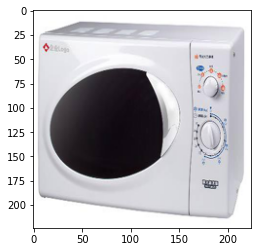

torch.return_types.topk(
values=tensor([0.9048, 0.0853, 0.0091], grad_fn=<TopkBackward>),
indices=tensor([129, 221,  65]))
['microwave_oven', 'washing_machine', 'electromagnetic_furnace']
['color: is black', 'color: is white', 'size: is big (compared to a mobile phone)', 'weight: weighs kilograms', 'shape: is cubic', 'parts: has an audio', 'parts: has a motor', 'parts: has a fan', 'parts: has keys', 'parts: has a plug', 'parts: has indicator lights', 'function: can give out lights', 'function: can give out sound', 'function: can heat', 'aim: is for business', 'aim: is for family', 'aim: is for display', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'material: is made of glass', 'existence: is common', 'existence: is movable', 'sound: is noisy', 'power: is a high-power (>100 w) device ']


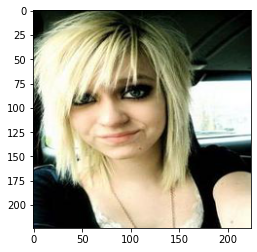

torch.return_types.topk(
values=tensor([9.9975e-01, 1.0238e-04, 7.9965e-05], grad_fn=<TopkBackward>),
indices=tensor([ 68, 120,  97]))
['emo_hair', 'liberty_spikes_hair', 'hime_cut']
['color: is golden', 'fitness: fits people with small eyes', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with ear rings', 'fitness: fits people with heavy make-up', 'feeling: is easy to be messy', 'feeling: is gorgeous', 'feeling: is cool', 'feeling: is lively']


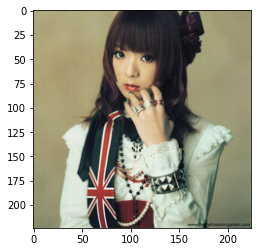

torch.return_types.topk(
values=tensor([0.9696, 0.0222, 0.0055], grad_fn=<TopkBackward>),
indices=tensor([ 97,  68, 143]))
['hime_cut', 'emo_hair', 'odango_hair']
['color: is brown', 'fitness: fits people with small eyes', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with ear rings', 'fitness: fits people with heavy make-up', 'feeling: is easy to be messy', 'feeling: is elegant', 'feeling: is cute', 'feeling: is pure', 'feeling: is lively', 'feeling: is naive']


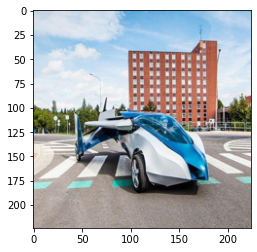

torch.return_types.topk(
values=tensor([9.9972e-01, 1.4571e-04, 7.1329e-05], grad_fn=<TopkBackward>),
indices=tensor([ 77,  27, 167]))
['flying_car', 'car', 'racing']
['color: is white', 'color: is cyan', 'size: is middle (compared to cars)', 'weight: weighs tons', 'shape: is long', 'speed: moves fast', 'parts: has doors', 'parts: has seats', 'parts: has windows', 'parts: has a engine', 'parts: has a horn', 'parts: has a steering wheel', 'parts: has a brake', 'parts: has a number plate', 'parts: has a propeller', 'parts: has four wheels', 'parts: has lights', 'function: can fly ', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a small quantity (≤ 1 ton) of goods', 'aim: is for civil use', 'aim: is for family', 'power: consumes gasoline', 'usage scenarios: can be used on urban roads', 'usage scenarios: can be used on rural roads', 'usage scenarios: can be used in the sky', 'safety: is dangerous', 'material:

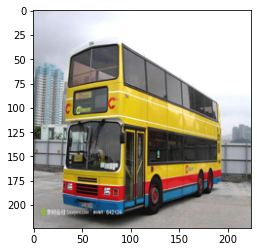

torch.return_types.topk(
values=tensor([9.9945e-01, 4.6966e-04, 4.5578e-05], grad_fn=<TopkBackward>),
indices=tensor([57, 39, 71]))
['double-decker_bus', 'coach', 'ferry']
['color: is black', 'color: is yellow', 'size: is big (compared to cars)', 'weight: weighs tons', 'shape: is long', 'speed: moves fast', 'parts: has doors', 'parts: has seats', 'parts: has windows', 'parts: has a engine', 'parts: has a horn', 'parts: has a steering wheel', 'parts: has a brake', 'parts: has a number plate', 'parts: has more than four wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a larger number (＞10)  of passengers', 'function: can carry a large quantity (＞ 1 tons) of goods', 'aim: is for civil use', 'power: consumes diesel oil', 'usage scenarios: can be used on urban roads', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


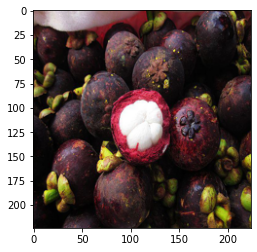

torch.return_types.topk(
values=tensor([0.9932, 0.0032, 0.0013], grad_fn=<TopkBackward>),
indices=tensor([128, 171, 124]))
['mangosteen', 'red_bayberry', 'lychee']
['outside color: is white', 'outside color: is red', 'outside color: is violet', 'outside color: is green', 'size: is small (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'taste: tastes bitter', 'taste: tastes sour', 'smell: is fragrant', 'epidermis: is rough', 'epidermis: has peel', 'current state: is complete', 'current state: is shredded', 'current state: is raw', 'current state: has been processed', 'hardness: is soft', 'hardness: is hard', 'edibility: is common', 'edibility: has a high water content', 'edibility: needs to be skinned', 'edibility: has nutlets', 'edibility: has seeds', 'growth: is tropical', 'growth: grows on trees', 'medicinal property: is cool or cold']


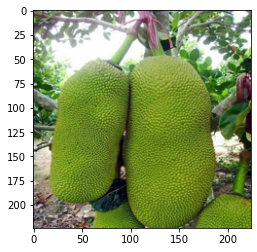

torch.return_types.topk(
values=tensor([9.9914e-01, 3.9948e-04, 1.2799e-04], grad_fn=<TopkBackward>),
indices=tensor([104,  90, 124]))
['jackfruit', 'gorilla', 'lychee']
['outside color: is cyan', 'outside color: is green', 'size: is big (compared to apples)', 'shape: is ellipsoidal', 'shape: is long', 'taste: tastes sweet', 'taste: tastes sour', 'smell: is smelly', 'marking: has patches', 'epidermis: is rough', 'epidermis: has peel', 'current state: is complete', 'current state: is raw', 'hardness: is hard', 'edibility: is rare', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: needs to be skinned', 'edibility: has nutlets', 'edibility: has seeds', 'growth: is tropical', 'growth: grows on trees', 'medicinal property: is mild']


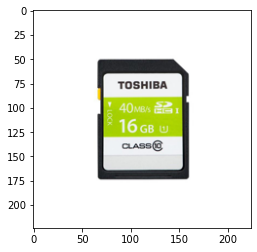

torch.return_types.topk(
values=tensor([9.9979e-01, 1.4605e-04, 5.6853e-05], grad_fn=<TopkBackward>),
indices=tensor([ 75, 131,  93]))
['flash_card', 'mobile_phone_battery', 'hard_disk']
['color: is black', 'color: is white', 'color: is cyan', 'color: is gray', 'size: is small (compared to a mobile phone)', 'shape: is schistose', 'shape: is flat', 'function: can heat', 'function: can storage data', 'aim: is for business', 'aim: is for family', 'aim: is for office use', 'aim: is for display', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is fixed', 'sound: is quiet', 'power: is a low-power (≤100 w) device']


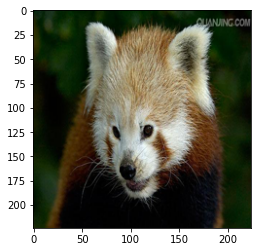

torch.return_types.topk(
values=tensor([0.9877, 0.0096, 0.0020], grad_fn=<TopkBackward>),
indices=tensor([119,  83,  79]))
['lesser_panda', 'giant_panda', 'fox']
['color: is white', 'color: is brown', 'color: is gray', 'color: is yellow', 'appearance: is furry', 'appearance: has soft skin', 'appearance: has whiskers', 'marking: has patches', 'size: is small (compared to pigs)', 'limb: has short legs', 'limb: has four legs', 'limb: has two arms', 'paws: has paws', 'paws: has pads', 'neck: has a long neck', 'teeth: has teeth', 'tail: has a long tail', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can walk', 'behaviour: can jump', 'behaviour: can climb trees', 'diet: eats plants', 'diet: eats insects', 'diet: eats fish', 'diet: eats leaves', 'diet: eats meat', 'diet: eats seeds', 'diet: eats nectar', 'habit: moves fast', 'habit: is weak', 'habit: has muscle', 'ha

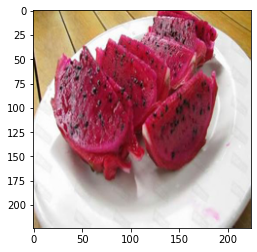

torch.return_types.topk(
values=tensor([9.9993e-01, 6.1119e-05, 5.5937e-06], grad_fn=<TopkBackward>),
indices=tensor([155, 224, 147]))
['pitaya', 'watermelon', 'papaya']
['outside color: is black', 'outside color: is red', 'size: is small (compared to apples)', 'shape: is ellipsoidal', 'shape: is long', 'taste: tastes sweet', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is shredded', 'current state: has been processed', 'hardness: is soft', 'edibility: is common', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: needs to be skinned', 'edibility: has seeds', 'growth: is tropical', 'medicinal property: is cool or cold']


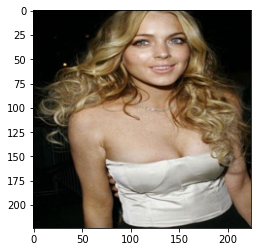

torch.return_types.topk(
values=tensor([0.8605, 0.0658, 0.0303], grad_fn=<TopkBackward>),
indices=tensor([175, 115, 218]))
['ringlet', 'layered_hair', 'waist-length_hair']
['color: is golden', 'fitness: fits people with small eyes', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with ear rings', 'fitness: fits people with heavy make-up', 'feeling: is easy to be messy', 'feeling: is gorgeous', 'feeling: is elegant', 'feeling: is sexy', 'feeling: is mature', 'feeling: is lively']


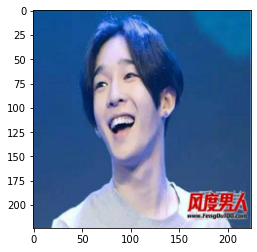

torch.return_types.topk(
values=tensor([9.9717e-01, 1.6482e-03, 4.3404e-04], grad_fn=<TopkBackward>),
indices=tensor([ 51, 156,  20]))
['curtained_hair', 'pixie_cut', 'bob_hair']
['color: is black', 'fitness: fits people with small eyes', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with heavy make-up', 'feeling: is easy to be messy', 'feeling: is simple', 'feeling: is elegant', 'feeling: is cute', 'feeling: is pure', 'feeling: is lively']


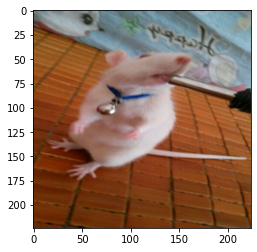

torch.return_types.topk(
values=tensor([9.9825e-01, 6.9407e-04, 2.3992e-04], grad_fn=<TopkBackward>),
indices=tensor([170, 109, 166]))
['rat', 'kiwi', 'rabbit']
['color: is white', 'appearance: is furry', 'appearance: has soft skin', 'appearance: has whiskers', 'size: is small (compared to pigs)', 'limb: has short legs', 'limb: has four legs', 'paws: has paws', 'paws: has pads', 'neck: has a long neck', 'teeth: has teeth', 'tail: has a long tail', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can walk', 'behaviour: can jump', 'behaviour: can climb trees', 'diet: eats plants', 'diet: eats insects', 'diet: eats fish', 'diet: eats leaves', 'diet: eats meat', 'diet: eats seeds', 'diet: eats nectar', 'habit: moves fast', 'habit: is weak', 'habit: has muscle', 'habit: is friendly', 'habit: is timid', 'habit: is active', 'habit: is nocturnal', 

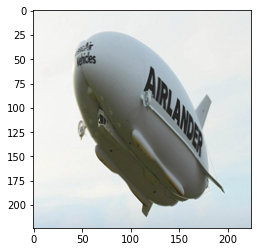

torch.return_types.topk(
values=tensor([9.9999e-01, 2.2825e-06, 9.9854e-07], grad_fn=<TopkBackward>),
indices=tensor([  4, 193,  86]))
['airship', 'submarine', 'glider']
['color: is white', 'size: is big (compared to cars)', 'weight: weighs tons', 'shape: is ellipsoidal', 'shape: is long', 'speed: moves slowly', 'parts: has a cable', 'function: can fly ', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a large quantity (＞ 1 tons) of goods', 'aim: is for engineering', 'aim: is for civil use', 'aim: is for military', 'power: consumes special fuel', 'usage scenarios: can be used in the sky', 'safety: is dangerous', 'material: is made of metal', 'material: is made of plastic', 'material: is made of cloth', 'price: is expensive']


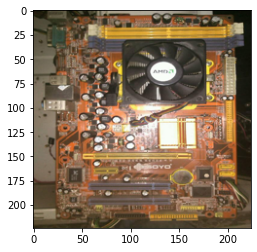

torch.return_types.topk(
values=tensor([9.6211e-01, 3.6002e-02, 5.6081e-04], grad_fn=<TopkBackward>),
indices=tensor([136, 163, 125]))
['motherboard', 'power_supply_unit', 'main_memory']
['color: is black', 'color: is brown', 'color: is yellow', 'size: is big (compared to a mobile phone)', 'shape: is schistose', 'shape: is flat', 'parts: has many usb interfaces', 'parts: has only one network interface', 'parts: has a headphone jack', 'parts: has indicator lights', 'function: can storage data', 'aim: is for business', 'aim: is for family', 'aim: is for office use', 'aim: is for display', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is fixed', 'sound: is quiet', 'power: is a low-power (≤100 w) device']


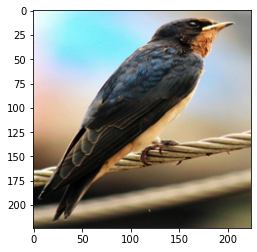

torch.return_types.topk(
values=tensor([9.9433e-01, 5.4916e-03, 6.5595e-05], grad_fn=<TopkBackward>),
indices=tensor([195, 188, 228]))
['swallow', 'sparrow', 'woodpecker']
['color: is black', 'color: is yellow', 'appearance: has soft skin', 'appearance: has feathers', 'appearance: is smooth', 'marking: has patches', 'marking: has stripes', 'size: is small (compared to pigs)', 'limb: has short legs', 'limb: is bipedal', 'limb: has two legs', 'wing: has long wings', 'paws: has paws', 'neck: has a long neck', 'tail: has a short tail', 'beak: has a needle beak', 'beak: has a short beak', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can fly', 'diet: eats plants', 'diet: eats insects', 'diet: eats leaves', 'diet: eats meat', 'diet: eats seeds', 'diet: eats nectar', 'habit: moves fast', 'habit: is weak', 'habit: has muscle', 'habit: is friendly', 'habit: is timid', 

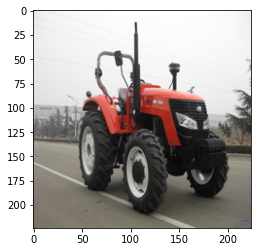

torch.return_types.topk(
values=tensor([9.9364e-01, 4.9016e-03, 8.6083e-04], grad_fn=<TopkBackward>),
indices=tensor([208,  87,  78]))
['tractor', 'go-kart', 'forklift']
['color: is black', 'color: is red', 'size: is middle (compared to cars)', 'speed: moves slowly', 'parts: has seats', 'parts: has a engine', 'parts: has a horn', 'parts: has a steering wheel', 'parts: has a brake', 'parts: has four wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a small quantity (≤ 1 ton) of goods', 'aim: is for engineering', 'aim: is for civil use', 'aim: is for family', 'power: consumes diesel oil', 'usage scenarios: can be used on urban roads', 'usage scenarios: can be used on rural roads', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


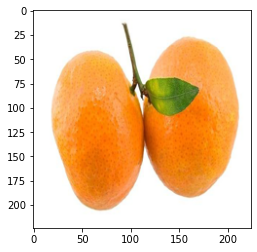

torch.return_types.topk(
values=tensor([0.7210, 0.1516, 0.0768], grad_fn=<TopkBackward>),
indices=tensor([  8, 127, 111]))
['apricot', 'mango', 'kumquat']
['outside color: is orange', 'outside color: is yellow', 'size: is small (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'taste: tastes sour', 'smell: is fragrant', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is complete', 'current state: is raw', 'hardness: is soft', 'edibility: is common', 'edibility: has a high water content', 'edibility: needs to be skinned', 'edibility: has seeds', 'growth: is tropical', 'growth: grows on trees', 'medicinal property: is warm or hot']


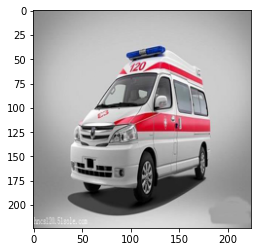

torch.return_types.topk(
values=tensor([9.9773e-01, 2.2229e-03, 2.2650e-05], grad_fn=<TopkBackward>),
indices=tensor([  5, 159, 223]))
['ambulance', 'police_car', 'watering_car']
['color: is white', 'color: is red', 'size: is big (compared to cars)', 'weight: weighs tons', 'shape: is long', 'speed: moves fast', 'parts: has doors', 'parts: has seats', 'parts: has windows', 'parts: has a engine', 'parts: has a horn', 'parts: has a steering wheel', 'parts: has a brake', 'parts: has a number plate', 'parts: has four wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a small quantity (≤ 1 ton) of goods', 'aim: is for rescue', 'power: consumes diesel oil', 'usage scenarios: can be used on urban roads', 'usage scenarios: can be used on rural roads', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


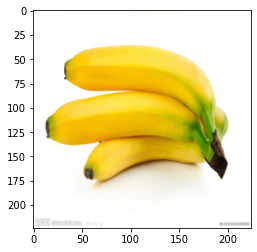

torch.return_types.topk(
values=tensor([9.9997e-01, 1.5372e-05, 6.3786e-06], grad_fn=<TopkBackward>),
indices=tensor([ 13,  90, 127]))
['banana', 'gorilla', 'mango']
['outside color: is yellow', 'size: is small (compared to apples)', 'shape: is long', 'taste: tastes sweet', 'smell: is fragrant', 'epidermis: is smooth', 'epidermis: is angular', 'epidermis: has peel', 'current state: is complete', 'current state: is raw', 'hardness: is soft', 'edibility: is common', 'edibility: has a high water content', 'edibility: needs to be skinned', 'growth: is tropical', 'growth: grows on trees', 'medicinal property: is cool or cold']


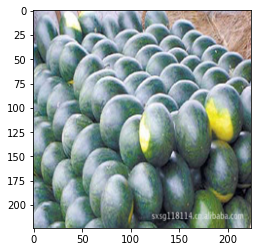

torch.return_types.topk(
values=tensor([0.5633, 0.2725, 0.1167], grad_fn=<TopkBackward>),
indices=tensor([224, 147,  92]))
['watermelon', 'papaya', 'hami_melon']
['outside color: is green', 'outside color: is yellow', 'size: is big (compared to apples)', 'shape: is ellipsoidal', 'shape: is long', 'taste: tastes sweet', 'marking: has stripes', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is complete', 'current state: is raw', 'edibility: is common', 'edibility: has a high water content', 'edibility: has seeds', 'growth: grows on the ground', 'medicinal property: is cool or cold']


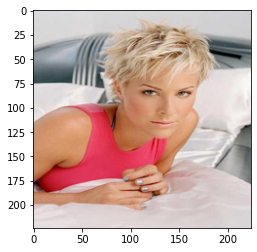

torch.return_types.topk(
values=tensor([0.5028, 0.4796, 0.0130], grad_fn=<TopkBackward>),
indices=tensor([156,  70, 181]))
['pixie_cut', 'fauxhawk', 'shoulder-length_hair']
['color: is golden', 'fitness: fits people with small eyes', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with ear rings', 'fitness: fits people with heavy make-up', 'feeling: is easy to be messy', 'feeling: is simple', 'feeling: is cute', 'feeling: is pure', 'feeling: is lively']


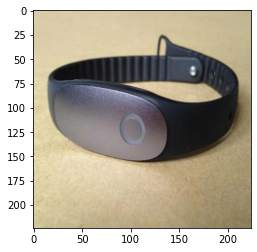

torch.return_types.topk(
values=tensor([9.9931e-01, 3.8813e-04, 1.8117e-04], grad_fn=<TopkBackward>),
indices=tensor([184,  18, 139]))
['smart_bracelet', 'bluetooth_headset', 'mp3_player']
['color: is black', 'color: is gray', 'size: is small (compared to a mobile phone)', 'parts: has a wrist band', 'parts: has a battery', 'parts: has indicator lights', 'function: can give out lights', 'function: can transmit signal', 'function: can storage data', 'function: can be located', 'aim: is for entertainment', 'aim: is for business', 'aim: is for family', 'aim: is for display', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is movable', 'sound: is quiet', 'usage mode: is handheld', 'power: is a low-power (≤100 w) device']


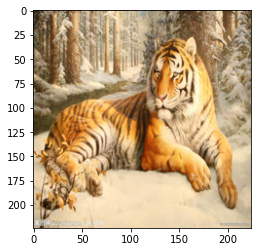

torch.return_types.topk(
values=tensor([9.9940e-01, 3.8440e-04, 8.1428e-05], grad_fn=<TopkBackward>),
indices=tensor([205, 121, 118]))
['tiger', 'lion', 'leopard']
['color: is black', 'color: is brown', 'color: is yellow', 'appearance: is furry', 'appearance: has soft skin', 'appearance: is smooth', 'appearance: has whiskers', 'marking: has stripes', 'size: is big (compared to pigs)', 'limb: has long legs', 'limb: has four legs', 'paws: has paws', 'paws: has pads', 'neck: has a long neck', 'teeth: has teeth', 'teeth: has buck teeth', 'tail: has a long tail', 'tail: has a colorful tail', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can walk', 'behaviour: can jump', 'diet: eats meat', 'habit: moves fast', 'habit: is strong', 'habit: has muscle', 'habit: is fierce', 'habit: is smart', 'habit: is active', 'habit: is the predator', 'habit: l

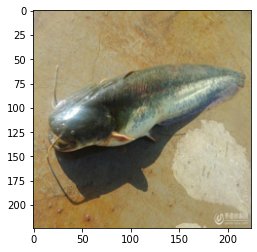

torch.return_types.topk(
values=tensor([9.9335e-01, 6.4537e-03, 1.2351e-04], grad_fn=<TopkBackward>),
indices=tensor([ 31,  29, 192]))
['catfish', 'carp', 'sturgeon']
['color: is gray', 'appearance: is hairless', 'appearance: has soft skin', 'appearance: is smooth', 'appearance: is mucous', 'appearance: has whiskers', 'marking: has patches', 'size: is small (compared to pigs)', 'teeth: has teeth', 'tail: has a long tail', 'other body parts: has eyes', 'other body parts: has fins', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can fish', 'diet: eats fish', 'diet: eats meat', 'diet: eats plankton', 'habit: moves fast', 'habit: is weak', 'habit: is friendly', 'habit: is timid', 'habit: is active', 'habit: is the predator', 'habit: lives in groups', 'habit: is quiet', 'habit: is cold-blooded', 'habitat: lives in water']


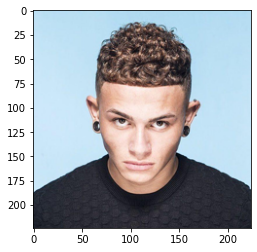

torch.return_types.topk(
values=tensor([0.9819, 0.0061, 0.0031], grad_fn=<TopkBackward>),
indices=tensor([ 50, 133,  76]))
['crop_hair', 'mohawk', 'flattop']
['color: is brown', 'fitness: fits people with small eyes', 'fitness: fits people with moustache', 'fitness: fits people with beard', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with a hat', 'feeling: is simple', 'feeling: is cute', 'feeling: is pure', 'feeling: is lively']


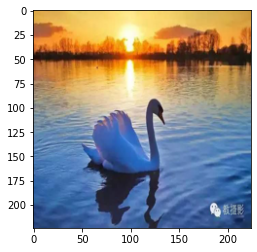

torch.return_types.topk(
values=tensor([0.7439, 0.2548, 0.0008], grad_fn=<TopkBackward>),
indices=tensor([196,  89,  55]))
['swan', 'goose', 'dolphin']
['color: is white', 'appearance: has soft skin', 'appearance: has feathers', 'size: is small (compared to pigs)', 'limb: has short legs', 'limb: is bipedal', 'limb: has two legs', 'limb: has two arms', 'wing: has long wings', 'paws: has paws', 'neck: has a short neck', 'tail: has a short tail', 'beak: has a short beak', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can fly', 'behaviour: can walk', 'behaviour: can lay eggs', 'behaviour: can fish', 'diet: eats plants', 'diet: eats insects', 'diet: eats fish', 'diet: eats leaves', 'diet: eats seeds', 'habit: moves fast', 'habit: is weak', 'habit: has muscle', 'habit: is friendly', 'habit: is timid', 'habit: is active', 'habit: lives in group

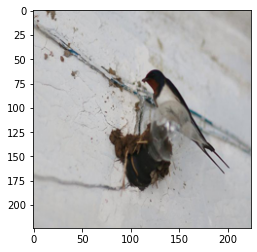

torch.return_types.topk(
values=tensor([9.9799e-01, 1.3614e-03, 5.3471e-04], grad_fn=<TopkBackward>),
indices=tensor([195, 188,  58]))
['swallow', 'sparrow', 'dragonfly']
['color: is black', 'color: is gray', 'appearance: has soft skin', 'appearance: has feathers', 'appearance: is smooth', 'marking: has patches', 'marking: has stripes', 'size: is small (compared to pigs)', 'limb: has short legs', 'limb: is bipedal', 'limb: has two legs', 'wing: has long wings', 'paws: has paws', 'neck: has a long neck', 'tail: has a short tail', 'beak: has a needle beak', 'beak: has a short beak', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can fly', 'diet: eats plants', 'diet: eats insects', 'diet: eats leaves', 'diet: eats meat', 'diet: eats seeds', 'diet: eats nectar', 'habit: moves fast', 'habit: is weak', 'habit: has muscle', 'habit: is friendly', 'habit: is timid', 'ha

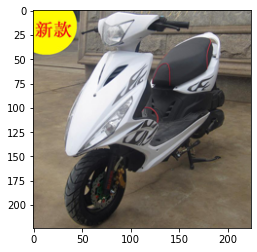

torch.return_types.topk(
values=tensor([0.7162, 0.2760, 0.0049], grad_fn=<TopkBackward>),
indices=tensor([137, 204,  87]))
['motorcycle', 'three-wheeled_motorcycle', 'go-kart']
['color: is black', 'color: is white', 'size: is small (compared to cars)', 'shape: is long', 'speed: moves fast', 'parts: has seats', 'parts: has a engine', 'parts: has a horn', 'parts: has a brake', 'parts: has a number plate', 'parts: has two wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a small quantity (≤ 1 ton) of goods', 'aim: is for civil use', 'aim: is for family', 'aim: is for sports', 'power: consumes gasoline', 'usage scenarios: can be used on urban roads', 'usage scenarios: can be used on rural roads', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


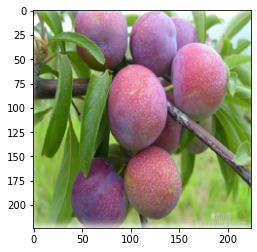

torch.return_types.topk(
values=tensor([9.9964e-01, 2.9746e-04, 1.3352e-05], grad_fn=<TopkBackward>),
indices=tensor([158, 144, 171]))
['plum', 'olive', 'red_bayberry']
['outside color: is red', 'outside color: is violet', 'size: is small (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'taste: tastes sour', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is complete', 'current state: is raw', 'hardness: is soft', 'edibility: is common', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: has nutlets', 'growth: grows on trees', 'medicinal property: is mild']


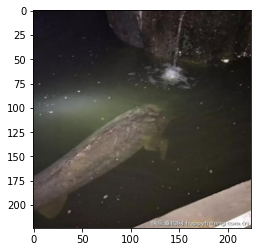

torch.return_types.topk(
values=tensor([0.4259, 0.3435, 0.2047], grad_fn=<TopkBackward>),
indices=tensor([157,  31, 192]))
['platypus', 'catfish', 'sturgeon']
['color: is gray', 'appearance: is hairless', 'appearance: has soft skin', 'appearance: is smooth', 'appearance: has shells', 'marking: has spots', 'size: is small (compared to pigs)', 'tail: has a long tail', 'other body parts: has eyes', 'other body parts: has fins', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can fish', 'diet: eats fish', 'diet: eats meat', 'diet: eats plankton', 'habit: moves fast', 'habit: is weak', 'habit: is friendly', 'habit: is timid', 'habit: is active', 'habit: is the predator', 'habit: lives in solitary', 'habit: is quiet', 'habit: is cold-blooded', 'habitat: lives in water', 'habitat: is endangered']


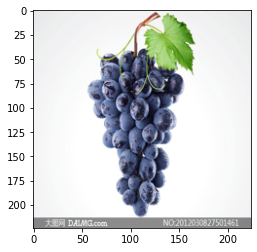

torch.return_types.topk(
values=tensor([1.0000e+00, 1.1300e-06, 5.2092e-08], grad_fn=<TopkBackward>),
indices=tensor([ 91,  17, 140]))
['grape', 'blueberry', 'mulberry_fruit']
['outside color: is black', 'size: is small (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'taste: tastes sour', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is complete', 'current state: is raw', 'hardness: is soft', 'edibility: is common', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: has seeds', 'growth: grows on trees', 'medicinal property: is mild']


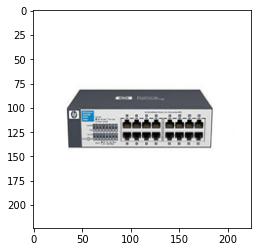

torch.return_types.topk(
values=tensor([0.9426, 0.0358, 0.0056], grad_fn=<TopkBackward>),
indices=tensor([197, 177, 114]))
['switch', 'router', 'laptop_power_adapter']
['color: is black', 'color: is gray', 'size: is big (compared to a mobile phone)', 'weight: weighs kilograms', 'shape: is flat', 'parts: has many network interfaces', 'parts: has keys', 'parts: has a plug', 'parts: has indicator lights', 'function: can give out lights', 'function: can transmit signal', 'function: can communicate in a short distance', 'function: can communicate in a long distance', 'aim: is for business', 'aim: is for communication', 'aim: is for family', 'aim: is for office use', 'aim: is for display', 'aim: is for safety', 'aim: is for personal', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is movable', 'sound: is quiet', 'power: is a low-power (≤100 w) device']


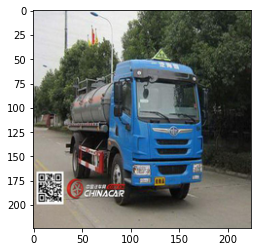

torch.return_types.topk(
values=tensor([0.9002, 0.0916, 0.0030], grad_fn=<TopkBackward>),
indices=tensor([201, 223, 212]))
['tank_truck', 'watering_car', 'truck']
['color: is blue', 'color: is gray', 'size: is big (compared to cars)', 'weight: weighs tons', 'shape: is long', 'speed: moves fast', 'parts: has doors', 'parts: has seats', 'parts: has windows', 'parts: has a engine', 'parts: has a horn', 'parts: has a steering wheel', 'parts: has a brake', 'parts: has a number plate', 'parts: has four wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a large quantity (＞ 1 tons) of goods', 'aim: is for engineering', 'aim: is for civil use', 'power: consumes diesel oil', 'usage scenarios: can be used on urban roads', 'usage scenarios: can be used on rural roads', 'safety: is dangerous', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


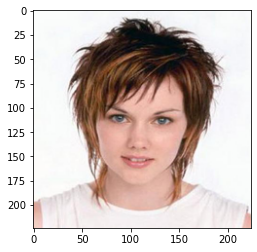

torch.return_types.topk(
values=tensor([0.6268, 0.2345, 0.0880], grad_fn=<TopkBackward>),
indices=tensor([156,  70, 135]))
['pixie_cut', 'fauxhawk', 'mop-top_hair']
['color: is brown', 'fitness: fits people with small eyes', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'feeling: is easy to be messy', 'feeling: is simple', 'feeling: is cute', 'feeling: is sexy', 'feeling: is mature', 'feeling: is pure']


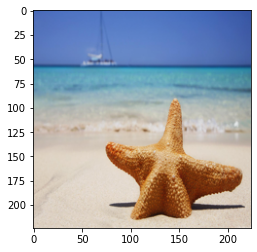

torch.return_types.topk(
values=tensor([9.4179e-01, 5.6988e-02, 5.6237e-04], grad_fn=<TopkBackward>),
indices=tensor([190, 178,  55]))
['starfish', 'sailing', 'dolphin']
['color: is yellow', 'appearance: is hairless', 'appearance: has soft skin', 'size: is small (compared to pigs)', 'limb: has tentacle', 'diet: eats fish', 'diet: eats meat', 'diet: eats plankton', 'habit: moves slow', 'habit: is weak', 'habit: is timid', 'habit: is the predator', 'habit: lives in groups', 'habit: is quiet', 'habit: is cold-blooded', 'habit: is venomous', 'habitat: lives in the ocean', 'habitat: lives in water']


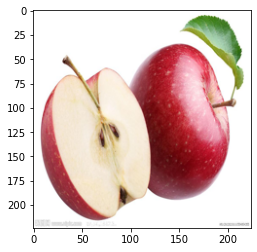

torch.return_types.topk(
values=tensor([0.9924, 0.0025, 0.0021], grad_fn=<TopkBackward>),
indices=tensor([  7, 149, 150]))
['apple', 'peach', 'pear']
['outside color: is red', 'size: is middle (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'taste: tastes sour', 'smell: is fragrant', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is complete', 'current state: is shredded', 'current state: is raw', 'current state: has been processed', 'hardness: is hard', 'edibility: is common', 'edibility: can be eaten directly', 'edibility: has a high water content', 'edibility: has nutlets', 'edibility: has seeds', 'growth: grows on trees', 'medicinal property: is warm or hot']


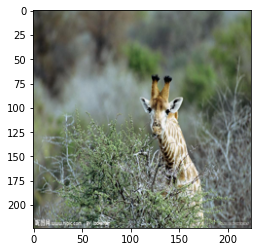

torch.return_types.topk(
values=tensor([0.4948, 0.3739, 0.1187], grad_fn=<TopkBackward>),
indices=tensor([118,  85, 228]))
['leopard', 'giraffe', 'woodpecker']
['color: is brown', 'color: is gray', 'appearance: has soft skin', 'appearance: is smooth', 'marking: has patches', 'size: is big (compared to pigs)', 'limb: has long legs', 'limb: has four legs', 'paws: has hooves', 'neck: has a short neck', 'teeth: has teeth', 'tail: has a long tail', 'horn: has short horns', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can walk', 'behaviour: can jump', 'diet: eats plants', 'diet: eats leaves', 'diet: eats seeds', 'diet: eats nectar', 'habit: moves fast', 'habit: is strong', 'habit: has muscle', 'habit: is friendly', 'habit: is timid', 'habit: is active', 'habit: lives in groups', 'habit: is quiet', 'habit: is warm-blooded', 'habit: can milk', 'habitat: lives in the 

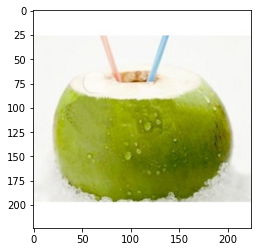

torch.return_types.topk(
values=tensor([0.6480, 0.1516, 0.0916], grad_fn=<TopkBackward>),
indices=tensor([ 92,  40, 147]))
['hami_melon', 'coconut', 'papaya']
['outside color: is white', 'outside color: is cyan', 'size: is big (compared to apples)', 'shape: is globular', 'taste: tastes sweet', 'epidermis: is smooth', 'epidermis: has peel', 'current state: is shredded', 'current state: has been processed', 'hardness: is hard', 'edibility: is common', 'edibility: has a high water content', 'growth: is tropical', 'growth: grows on trees', 'medicinal property: is mild']


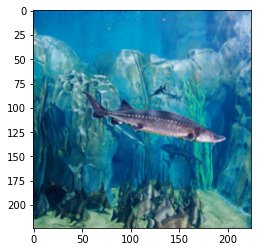

torch.return_types.topk(
values=tensor([9.6994e-01, 2.9148e-02, 4.1430e-04], grad_fn=<TopkBackward>),
indices=tensor([192, 180, 157]))
['sturgeon', 'shark', 'platypus']
['color: is gray', 'appearance: is hairless', 'appearance: has soft skin', 'appearance: is smooth', 'appearance: has shells', 'marking: has spots', 'size: is small (compared to pigs)', 'tail: has a long tail', 'other body parts: has eyes', 'other body parts: has fins', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can fish', 'diet: eats fish', 'diet: eats meat', 'diet: eats plankton', 'habit: moves fast', 'habit: is weak', 'habit: is friendly', 'habit: is timid', 'habit: is active', 'habit: is the predator', 'habit: lives in solitary', 'habit: is quiet', 'habit: is cold-blooded', 'habitat: lives in water', 'habitat: is endangered']


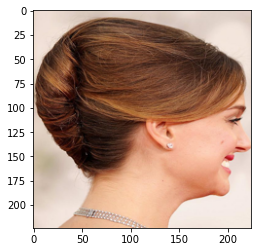

torch.return_types.topk(
values=tensor([9.9996e-01, 2.1247e-05, 1.2011e-05], grad_fn=<TopkBackward>),
indices=tensor([ 81,  22, 162]))
['french_twist', 'bun_hair', 'ponytail']
['color: is brown', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with ear rings', 'fitness: fits people with heavy make-up', 'feeling: is gorgeous', 'feeling: is elegant', 'feeling: is sexy', 'feeling: is mature', 'feeling: is pure']


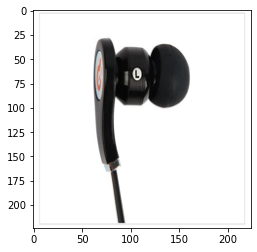

torch.return_types.topk(
values=tensor([7.3394e-01, 2.6349e-01, 7.3042e-04], grad_fn=<TopkBackward>),
indices=tensor([ 63,  18, 198]))
['earphones', 'bluetooth_headset', 'table_lamp']
['color: is black', 'size: is small (compared to a mobile phone)', 'parts: has an audio', 'parts: has a headphone jack', 'function: can give out sound', 'function: can play music', 'aim: is for entertainment', 'aim: is for business', 'aim: is for communication', 'aim: is for family', 'aim: is for office use', 'aim: is for display', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is movable', 'power: is a low-power (≤100 w) device']


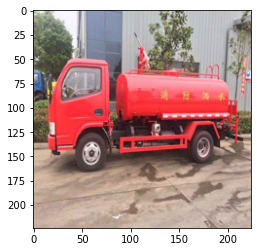

torch.return_types.topk(
values=tensor([0.7978, 0.1940, 0.0040], grad_fn=<TopkBackward>),
indices=tensor([223, 201,  48]))
['watering_car', 'tank_truck', 'crane']
['color: is red', 'size: is big (compared to cars)', 'weight: weighs tons', 'shape: is long', 'speed: moves fast', 'parts: has doors', 'parts: has seats', 'parts: has windows', 'parts: has a engine', 'parts: has a horn', 'parts: has a steering wheel', 'parts: has a brake', 'parts: has a number plate', 'parts: has four wheels', 'parts: has lights', 'function: can move', 'function: can be driven', 'function: can carry a small number (≤10) of passengers', 'function: can carry a small quantity (≤ 1 ton) of goods', 'aim: is for cleaning', 'power: consumes diesel oil', 'usage scenarios: can be used on urban roads', 'usage scenarios: can be used on rural roads', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'price: is expensive']


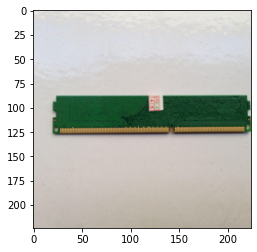

torch.return_types.topk(
values=tensor([9.9963e-01, 2.3929e-04, 7.5288e-05], grad_fn=<TopkBackward>),
indices=tensor([125,  47, 131]))
['main_memory', 'cpu', 'mobile_phone_battery']
['color: is green', 'size: is middle (compared to a mobile phone)', 'shape: is schistose', 'shape: is flat', 'function: can storage data', 'aim: is for business', 'aim: is for family', 'aim: is for office use', 'aim: is for display', 'aim: is for safety', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is movable', 'existence: is fixed', 'sound: is quiet', 'power: is a low-power (≤100 w) device']


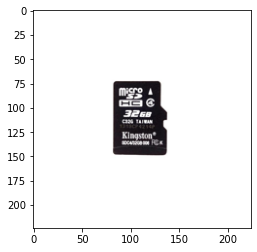

torch.return_types.topk(
values=tensor([0.8948, 0.0997, 0.0032], grad_fn=<TopkBackward>),
indices=tensor([ 75, 131,  93]))
['flash_card', 'mobile_phone_battery', 'hard_disk']
['color: is black', 'color: is white', 'size: is small (compared to a mobile phone)', 'shape: is schistose', 'shape: is flat', 'function: can heat', 'function: can storage data', 'aim: is for business', 'aim: is for family', 'aim: is for office use', 'aim: is for display', 'aim: is for personal', 'safety: is safe', 'material: is made of metal', 'material: is made of plastic', 'existence: is common', 'existence: is fixed', 'sound: is quiet', 'power: is a low-power (≤100 w) device']


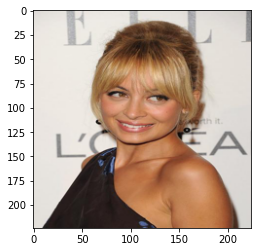

torch.return_types.topk(
values=tensor([8.1770e-01, 1.8169e-01, 1.7140e-04], grad_fn=<TopkBackward>),
indices=tensor([ 81, 115, 181]))
['french_twist', 'layered_hair', 'shoulder-length_hair']
['color: is brown', 'color: is golden', 'fitness: fits fair-skinned people', 'fitness: fits people with a pointed nose', 'fitness: fits people with ear rings', 'fitness: fits people with heavy make-up', 'feeling: is gorgeous', 'feeling: is elegant', 'feeling: is sexy', 'feeling: is mature', 'feeling: is pure']


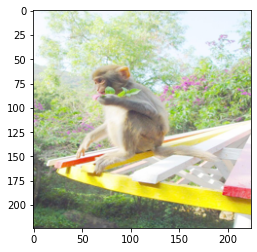

torch.return_types.topk(
values=tensor([0.9926, 0.0022, 0.0010], grad_fn=<TopkBackward>),
indices=tensor([134, 170, 110]))
['monkey', 'rat', 'koala']
['color: is brown', 'color: is gray', 'appearance: is furry', 'appearance: has soft skin', 'marking: has patches', 'size: is small (compared to pigs)', 'limb: has long legs', 'limb: has four legs', 'limb: has two arms', 'paws: has paws', 'paws: has pads', 'neck: has a long neck', 'teeth: has teeth', 'tail: has a long tail', 'other body parts: has a tongue', 'other body parts: has eyes', 'other body parts: has ears', 'other body parts: has a nose', 'other body parts: has a backbone', 'behaviour: can swim', 'behaviour: can walk', 'behaviour: can jump', 'behaviour: can climb trees', 'diet: eats plants', 'diet: eats insects', 'diet: eats fish', 'diet: eats leaves', 'diet: eats meat', 'diet: eats seeds', 'diet: eats nectar', 'habit: moves fast', 'habit: is weak', 'habit: has muscle', 'habit: is friendly', 'habit: is timid', 'habit: is smart', 

In [28]:
data = next(iter(testloader))
image_batch, text_batch, label_batch, idx_batch = data['image'], data['attribute'], data['label'], data['data_indx']
outputs = model(image_batch, text_batch)

for id in range(64):
    plt.imshow(images[idx_batch[id]].cpu().detach().permute(1, 2, 0))
    plt.show()
    print(m(outputs[id]).cpu().topk(3, dim=-1))
    top3 = m(outputs[id]).cpu().topk(3, dim=-1).indices
    print([class_list[i] for i in top3])
    print(attr[idx_batch[id]])